In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import glob

In [3]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

#ee.Initialize()

In [38]:
#Station coordinates (FLATS around stations?)

stazioni = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/All_stations2.csv')

# print(stazioni['Station Code'].unique())

stazioni = stazioni[stazioni['Station Code'].str.contains('nut')]

stazioni.rename(columns={"Latitude ": "Latitude", " Longitude": "Longitude"}, inplace= True)

dfs = stazioni[['Station Code', 'Station Name', 'Latitude', 'Longitude']]

dfx = dfs[dfs['Station Code']=='sapdcnut  '] #two spaces put in after each code for some stupid fucking reason

dfx

,Station Code,Station Name,Latitude,Longitude
267,sapdcnut,Dean Creek,31.3896,-81.2789


In [39]:
px = ee.Geometry.Point([dfx.iloc[0,3], dfx.iloc[0,2]])


In [40]:
Map = geemap.Map(center=[31.3896,-81.2789], zoom=16)

# Map

In [41]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

gce_lter = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE domain/GCE_LTER_boundary.shp')

#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000)) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)

In [43]:
dean_nut = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE domain/Dean_creek2.shp')

Map.addLayer(l8_col.first(), {'bands': ['SR_B5',  'SR_B4',  'SR_B3'], 'min': 0, 'max': 0.2}, 'Landsat 8')

Map.addLayer(dean_nut, {}, 'Dean creek')
Map.addLayer(px,{},'station')
# Map

In [44]:
ultra_col = l5_col.merge(l7_col).merge(l8_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
ultra = ultra_col.filter(ee.Filter.calendarRange(2004, 2024,'year')).map(lambda image: image.clip(dean_nut)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [45]:
def area_extract(image):
    
    feature = ee.Image(image).reduceRegions(
        collection = dean_nut,
        reducer = ee.Reducer.mean(),
        scale=30
    )
    
    return feature

#reduceRegion doesn't work (geometry instead of collection) - why? maybe loop below is the issue

In [46]:
im_list = ultra.toList(ultra.size())

In [47]:
#Extraction - takes a long time!
feature_list = ultra.map(area_extract).flatten().toList(ultra.size())
values_list = []

# Loop through the feature list and extract values
for i in range(feature_list.size().getInfo()):
    feature = ee.Feature(feature_list.get(i))
    properties = feature.toDictionary()
    values_list.append(properties.getInfo())

# Convert the list of dictionaries to a pandas DataFrame
timeseries_df = pd.DataFrame(values_list)

# Print the DataFrame
print(timeseries_df)

      QA_PIXEL  QA_RADSAT  SR_ATMOS_OPACITY     SR_B1     SR_B2     SR_B3  \
0       5440.0        0.0             164.0  0.044666  0.056518  0.055237   
1       5440.0        0.0             213.0  0.046207  0.056226  0.056127   
2       5440.0        0.0             231.0  0.041903  0.056902  0.055558   
3       5440.0        0.0             163.0  0.052074  0.067641  0.065196   
4       5440.0        0.0             191.0  0.047958  0.069970  0.066082   
...        ...        ...               ...       ...       ...       ...   
1106       NaN        NaN               NaN       NaN       NaN       NaN   
1107       NaN        NaN               NaN       NaN       NaN       NaN   
1108       NaN        NaN               NaN       NaN       NaN       NaN   
1109       NaN        NaN               NaN       NaN       NaN       NaN   
1110   21824.0        0.0               NaN  0.034652  0.041631  0.052642   

         SR_B4     SR_B5     SR_B7  ST_ATRAN  ...      ST_TRAD  ST_URAD  \


In [70]:
import os
out_dir = os.path.expanduser('C:/Users/arj26323/Documents/Data/NERR data/')
out_csv = os.path.join(out_dir, 'timeseries_area2.csv')
# timeseries_df.to_csv(out_csv, index = False)

In [26]:
timeseries_df = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/timeseries_area2.csv') #a couple versions

timeseries_df['Date'] = pd.to_datetime(timeseries_df['acquisition_date'], unit = 'ms')
timeseries_df['DOY'] = timeseries_df['Date'].dt.strftime('%Y-%m-%d')
timeseries_df['DOY'] = pd.to_datetime(timeseries_df['DOY'])

timeseries_df

,ACRES,ATTRIBUTE,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,...,Shape_Le_1,Shape_Leng,WETLAND_TY,acquisition_date,flats,SR_B6,SR_QA_AEROSOL,ST_B10,Date,DOY
0,39.636886,E2EM1N,5440.042828,0.0,160.271397,0.039264,0.049402,0.048584,0.094076,0.109687,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1074094403292,0.019385,NaN,NaN,NaN,2004-01-14 15:33:23.292,2004-01-14
1,39.636886,E2EM1N,5440.000000,0.0,214.645497,0.039100,0.051151,0.051950,0.104133,0.127877,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1078241617260,0.007255,NaN,NaN,NaN,2004-03-02 15:33:37.260,2004-03-02
2,39.636886,E2EM1N,5440.000000,0.0,232.040658,0.038376,0.048971,0.048653,0.102960,0.116635,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1079624023654,0.011103,NaN,NaN,NaN,2004-03-18 15:33:43.654,2004-03-18
3,39.636886,E2EM1N,5440.000000,0.0,159.870579,0.041319,0.054702,0.054956,0.115190,0.130249,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1081006436331,0.009953,NaN,NaN,NaN,2004-04-03 15:33:56.331,2004-04-03
4,39.636886,E2EM1N,5440.000000,0.0,191.903612,0.043904,0.058226,0.058720,0.129604,0.137280,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1082388866855,0.006848,NaN,NaN,NaN,2004-04-19 15:34:26.855,2004-04-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1694707252757,NaN,NaN,NaN,NaN,2023-09-14 16:00:52.757,2023-09-14
1672,39.636886,E2EM1N,21959.198241,0.0,NaN,0.049953,0.054009,0.067340,0.061272,0.108036,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1696089650784,0.449131,0.079140,101.184731,297.292871,2023-09-30 16:00:50.784,2023-09-30
1673,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1697472062494,NaN,NaN,NaN,NaN,2023-10-16 16:01:02.494,2023-10-16
1674,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3417.363646,3417.363646,Estuarine and Marine Wetland,1698854456167,NaN,NaN,NaN,NaN,2023-11-01 16:00:56.167,2023-11-01


<Axes: xlabel='Date', ylabel='flats'>

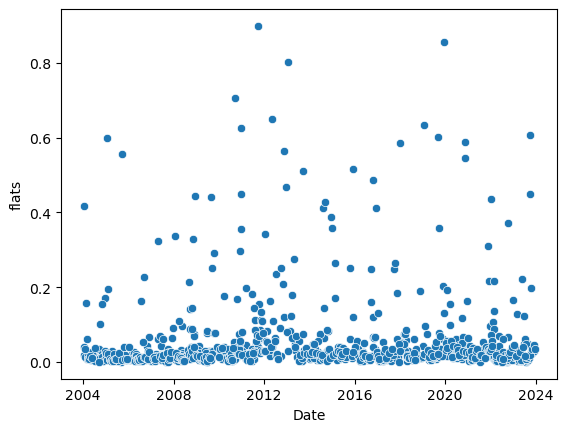

In [27]:
import seaborn as sns
sns.scatterplot(data = timeseries_df, x = 'Date', y = 'flats')

In [ ]:
##LANDSAT ACQUISITION TIME!!! FOR TIDE/TIME MERGING

In [28]:
#Tides

path = r'C:/Users/arj26323/Documents/Data/Tide data/GA_FortPulaski' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_tides = pd.concat(li, axis=0, ignore_index=True)

df2 = df_tides.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])
df_time = df2.copy()
df_time['Verified (m)'] = df_time['Verified (m)'].replace('-', float('nan')).astype('float')
df_time = df_time.dropna()
df_time['Tide change'] = df_time['Verified (m)'].diff()
df_time['Tide stage'] = df_time['Tide change'].apply(lambda x: 'Ebb' if x < 0 else 'Flood')

time_mask = (df_time['Time (GMT)'].dt.hour == 16)

df_time = df_time[time_mask]


##Combine time/tide and flats data
df_combined = pd.merge(timeseries_df, df_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']
df_combined

C:\Users\arj26323\AppData\Local\Temp\ipykernel_10724\411532214.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])


,ACRES,ATTRIBUTE,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,...,Date_x,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Tide change,Tide stage,Date
0,39.636886,E2EM1N,5440.042828,0.0,160.271397,0.039264,0.049402,0.048584,0.094076,0.109687,...,2004-01-14 15:33:23.292,2004-01-14,2004/01/14,2024-05-03 16:00:00,1.663,-,1.764,0.473,Flood,2004-01-14 15:33:23.292
1,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2004-01-14 15:33:47.408,2004-01-14,2004/01/14,2024-05-03 16:00:00,1.663,-,1.764,0.473,Flood,2004-01-14 15:33:47.408
2,39.636886,E2EM1N,5440.000000,0.0,214.645497,0.039100,0.051151,0.051950,0.104133,0.127877,...,2004-03-02 15:33:37.260,2004-03-02,2004/03/02,2024-05-03 16:00:00,0.344,-,0.128,-0.045,Ebb,2004-03-02 15:33:37.260
3,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2004-03-02 15:34:01.376,2004-03-02,2004/03/02,2024-05-03 16:00:00,0.344,-,0.128,-0.045,Ebb,2004-03-02 15:34:01.376
4,39.636886,E2EM1N,5440.000000,0.0,232.040658,0.038376,0.048971,0.048653,0.102960,0.116635,...,2004-03-18 15:33:43.654,2004-03-18,2004/03/18,2024-05-03 16:00:00,0.291,-,0.347,-0.537,Ebb,2004-03-18 15:33:43.654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,39.636886,E2EM1N,21824.000000,0.0,NaN,0.024396,0.030153,0.045574,0.042464,0.116868,...,2023-04-23 16:00:38.084,2023-04-23,2023/04/23,2024-05-03 16:00:00,1.915,-,2.143,-0.091,Ebb,2023-04-23 16:00:38.084
1628,39.636886,E2EM1N,21824.000000,0.0,NaN,0.033577,0.039702,0.051049,0.046170,0.103777,...,2023-05-25 16:00:16.596,2023-05-25,2023/05/25,2024-05-03 16:00:00,1.608,-,2.115,0.251,Flood,2023-05-25 16:00:16.596
1629,39.636886,E2EM1N,21824.000000,0.0,NaN,0.029448,0.032379,0.041642,0.037020,0.091154,...,2023-06-26 16:00:08.772,2023-06-26,2023/06/26,2024-05-03 16:00:00,1.236,-,1.452,0.385,Flood,2023-06-26 16:00:08.772
1630,39.636886,E2EM1N,21824.000000,0.0,NaN,0.040933,0.043156,0.055090,0.050619,0.137877,...,2023-07-12 16:00:23.748,2023-07-12,2023/07/12,2024-05-03 16:00:00,0.216,-,0.569,0.282,Flood,2023-07-12 16:00:23.748


<Axes: xlabel='Date', ylabel='flats'>

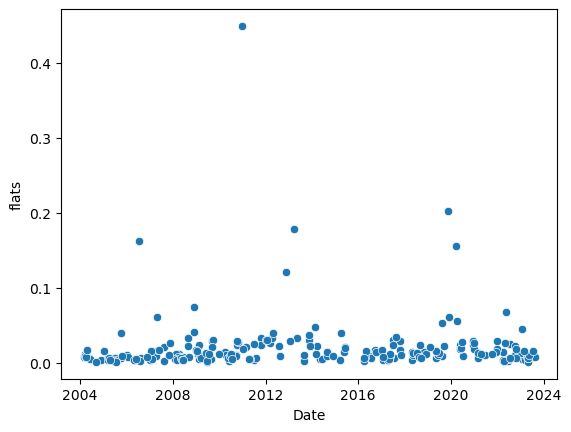

In [29]:
import seaborn as sns

dfy = df_combined[df_combined['Verified (m)'] < 0.6]

sns.scatterplot(data = dfy, x = 'Date', y = 'flats')

<Axes: xlabel='Verified (m)', ylabel='flats'>

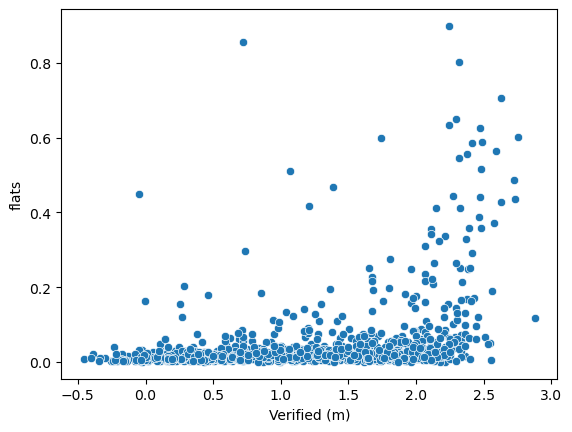

In [30]:
sns.scatterplot(data = df_combined, x = 'Verified (m)', y = 'flats') #This relationship seems ok

In [31]:
##Adding nutrient data

##SAP station
path = r'C:/Users/arj26323/Documents/Data/NERR data/Files 2024' #changed from Files folder 4/25/24
all_files = glob.glob(path + "/sapdcnut*.csv")

li = []

for filename in all_files:
    df_sap = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_sap)

df_sap = pd.concat(li, axis=0, ignore_index=True).dropna(subset=['NO23F']).dropna(axis=1)

##Begin:
df_sap = df_sap[df_sap['NO23F'] < 0.9] ##removes several extremely large outliers
df_sap['Date_m'] = pd.to_datetime(df_sap['DateTimeStamp'])
df_sap['DOY'] = df_sap['Date_m'].dt.strftime('%Y-%m-%d')
df_sap['DOY'] = pd.to_datetime(df_sap['DOY'])

df_sap

,StationCode,isSWMP,DateTimeStamp,Historical,ProvisionalPlus,CollMethd,REP,F_PO4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY
0,sapdcnut,P,09/22/2004 10:35,1,1,1,1,<4>,<4> H,<4> B - H,<4> B - C,0.0210,<4>,<4>,2004-09-22 10:35:00,2004-09-22
1,sapdcnut,P,09/22/2004 10:36,1,1,1,S,<4>,<4> H,<4> B - H,<4> B - C,0.0210,<4>,<4>,2004-09-22 10:36:00,2004-09-22
2,sapdcnut,P,09/22/2004 10:43,1,1,1,2,<4>,<4> H,<4> B - H,<4> B - C,0.0180,<4>,<4>,2004-09-22 10:43:00,2004-09-22
3,sapdcnut,P,09/22/2004 10:44,1,1,1,S,<4>,<4> H,<4> B - H,<4> B - C,0.0180,<4>,<4>,2004-09-22 10:44:00,2004-09-22
4,sapdcnut,P,09/22/2004 10:52,1,1,1,3,<4>,<4> H,<4> B - H,<4> B - C,0.0180,<4>,<4>,2004-09-22 10:52:00,2004-09-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,sapdcnut,P,10/20/2022 10:17,0,1,1,2,<0>,<0>,<0>,<0>,0.0101,<0>,<0>,2022-10-20 10:17:00,2022-10-20
772,sapdcnut,P,11/23/2022 9:42,0,1,1,1,<0>,<0>,<0>,<0>,0.0063,<0>,<0>,2022-11-23 09:42:00,2022-11-23
773,sapdcnut,P,11/23/2022 9:47,0,1,1,2,<0>,<0>,<0>,<-4> [SCB],0.0055,<-4> [SBL],<0>,2022-11-23 09:47:00,2022-11-23
774,sapdcnut,P,12/22/2022 9:20,0,1,1,1,<0>,<0>,<-4> [SBL],<-4> [SCB],0.0055,<-4> [SBL],<0>,2022-12-22 09:20:00,2022-12-22


<Axes: xlabel='Date_m', ylabel='NO23F'>

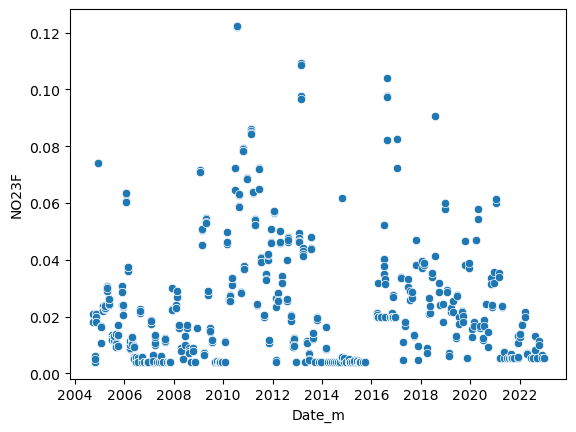

In [32]:
sns.scatterplot(data = df_sap, x = 'Date_m', y = 'NO23F')

In [33]:
##Merge, to nearest Landsat acquisition
df_combined2 = pd.merge_asof(
    df_combined.sort_values('Date'), 
    df_sap.sort_values('Date_m'), 
    left_on = 'Date',
    right_on = 'Date_m', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("1210000000ms") ##Two weeks - is this ok?
)

df_combined2

,ACRES,ATTRIBUTE,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,...,REP,F_PO4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY_y
0,39.636886,E2EM1N,5440.042828,0.0,160.271397,0.039264,0.049402,0.048584,0.094076,0.109687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,39.636886,E2EM1N,5457.360717,0.0,13.565817,0.038053,0.045478,0.043958,0.064437,0.053429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,39.636886,E2EM1N,5441.320357,0.0,185.067205,0.032485,0.038649,0.040302,0.080952,0.084813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1628,39.636886,E2EM1N,21824.000000,0.0,NaN,0.036589,0.040775,0.055180,0.051837,0.142208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1629,39.636886,E2EM1N,21824.000000,0.0,NaN,0.045278,0.049179,0.064664,0.056279,0.152553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1630,39.636886,E2EM1N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [34]:
len(df_combined2['NO23F'].dropna())

1248

<Axes: xlabel='NO23F', ylabel='flats'>

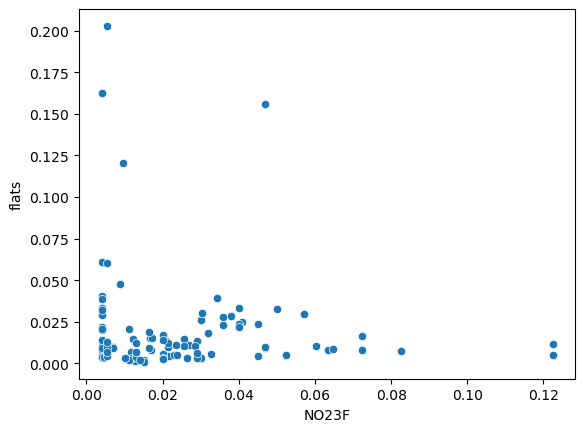

In [35]:
import seaborn as sns
import matplotlib as plt

dfz = df_combined2[df_combined2['Verified (m)'] < 0.3]

sns.scatterplot(data = dfz, x = 'NO23F', y = 'flats') ##This doesn't really tell you much. Need time + flats + N

In [36]:
print(dfz.shape)

##Tide quantiles will be different

max(dfz['Verified (m)'])

# dfz.quantile([.25, .5, 0.75])

df_combined['Verified (m)'].quantile([0,.25, .5, 0.75, 1])

(217, 56)


0.00   -0.45500
0.25    0.61975
0.50    1.27000
0.75    1.91325
1.00    2.87800
Name: Verified (m), dtype: float64

-0.08524501811810153
Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = 0): -0.09


<Axes: xlabel='NO23F', ylabel='flats'>

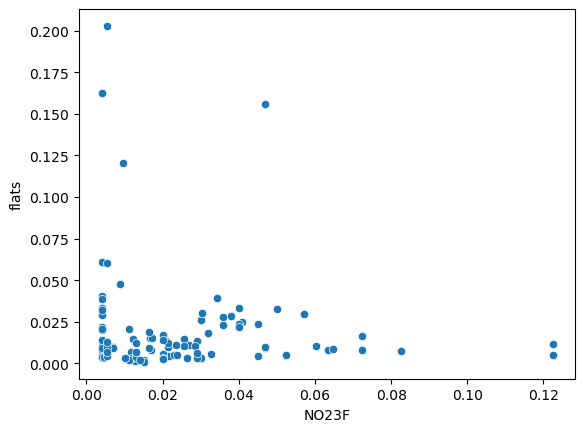

In [37]:
correlation = dfz['flats'].corr(dfz['NO23F'])
print(correlation)


##Time lag
lag = 0 #why choose this number?

no23_shifted = dfz['NO23F'].shift(-lag)

no23_shifted = no23_shifted.dropna()

# Calculate the correlation between the shifted variable and the original variable
time_lagged_corr = dfz['flats'].corr(no23_shifted)

# Print the time lagged correlation coefficient
print("Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = {}): {:.2f}".format(lag, time_lagged_corr))

sns.scatterplot(x = no23_shifted, y = dfz['flats']) ##This doesn't really tell you much. Need time + flats + N

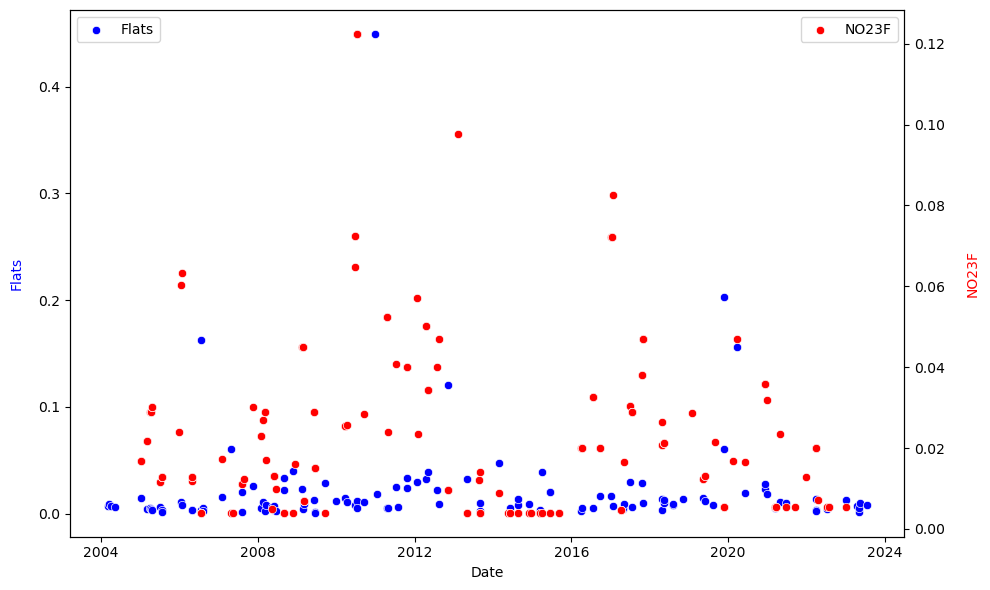

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (flats)
sns.scatterplot(ax=ax1, data=dfz, x='Date', y='flats', label='Flats', color='blue')
ax1.set_ylabel('Flats', color='blue', labelpad=10)

# Secondary y-axis (NO23F)
ax2 = ax1.twinx()  # Create a twin axis that shares the x-axis
sns.scatterplot(ax=ax2, data=dfz, x='Date', y='NO23F', label='NO23F', color='red')
ax2.set_ylabel('NO23F', color='red',  labelpad=15)

# Customize the plot further (optional)
# Place legend on primary y-axis
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')  

# Alternatively, place legend on secondary y-axis
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper right')


plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()